## Paolo's code refactoring from Syed's original
https://github.com/PaoloMissier/MLTC-Patient_modelling/tree/master/notebooks/SYED

In [1]:
import pandas as pd
import numpy as np
import math
from os.path import exists

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools

## local imports
from  CommonFunctions import *
from Constants import *

# Pre-Processing

In [2]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pipeline execution

## from the binary matrix, create the bag of words to feed LDA

In [3]:
## use cached pickle files if available 
## for bows
## for list_of_ltcs

if exists(BOWs) and not FORCE_RECOMPUTE:
    with open(BOWs, 'rb') as f:
      bows =  pickle.load(f)
    print('loaded BOW list [{0}] from cache'.format(BOWs))

    with open(LTCs, 'rb') as f:
      list_of_ltcs =  pickle.load(f)
    print('loaded LTC list [{0}] from cache'.format(LTCs))
    
else:
    ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')
    bows, list_of_ltcs = create_bows(ltc_patients)
    
print("working with {0} bows (= patients)".format(len(bows)))

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loaded BOW list [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/generated/BOWs.pkl] from cache
loaded LTC list [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/generated/LTCSs.pkl] from cache
working with 143168 bows (= patients)


### summary stats about our bags of words

In [4]:
all_len = 0

for text in bows:
    all_len += len(text)
    
avg_len = all_len/len(bows)

print("All words: {n}".format(n=all_len))
print("Average LTCs per patient: {n}".format(n=avg_len))
print("Maximum amount of LTCs: {n}".format(n= max(len(x) for x in bows)))
print("Minimum amount of LTCs: {n}".format(n= min(len(x) for x in bows)))
print("Patients in corpus: {l}".format(l=len(bows)))
print("Example of patient record:\n {n}".format(n=bows[1]))

All words: 1104514
Average LTCs per patient: 7.714810572194904
Maximum amount of LTCs: 37
Minimum amount of LTCs: 4
Patients in corpus: 143168
Example of patient record:
 ['female_genital_prolapse', 'fracture_hip', 'obesity', 'spondylosis', 'type_2_diabetes', 'unspecified_rare_diabetes', 'urine_incont']


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


### distribution of disease terms in the corpus

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


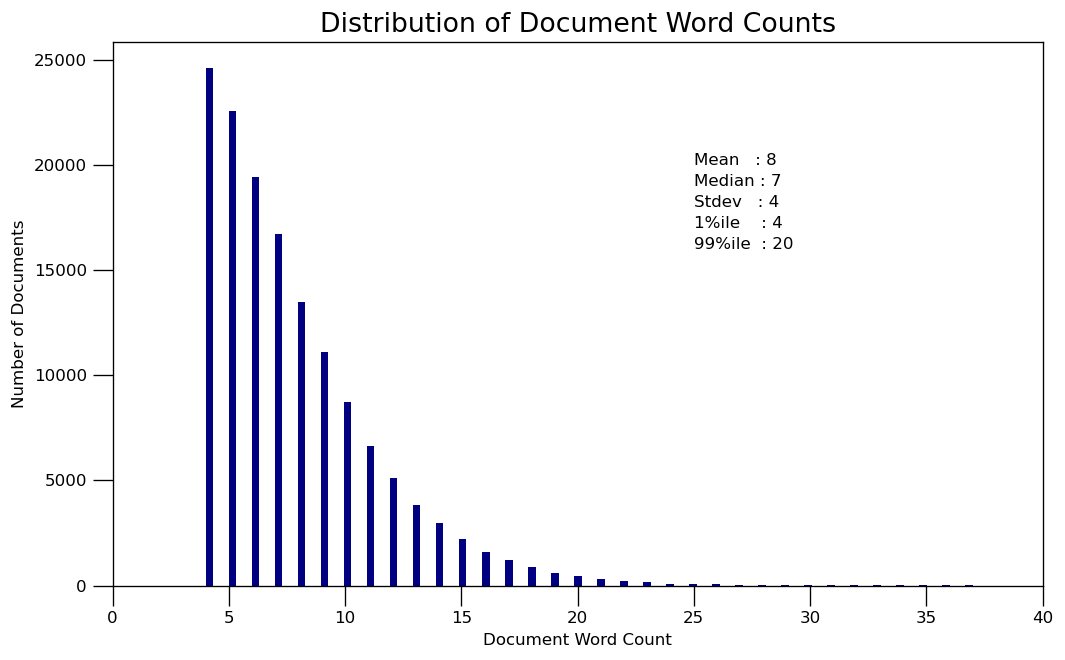

In [5]:
doc_lens = [len(d) for d in bows]

# Plot
plt.figure(figsize=(10,6), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(25, 20000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25,  19000, "Median : " + str(round(np.median(doc_lens))))
plt.text(25,  18000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25,  17000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25,  16000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,40,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

## Topics generation

### set numbers of target topics

In [6]:
topics_count = 5
# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### load / generate topic model

In [7]:
FORCE_RECOMPUTE = True

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
if exists(LDA_MODEL) and not FORCE_RECOMPUTE:
    with open(LDA_MODEL, 'rb') as f:
      lda_model = pickle.load(f)
      print('loaded model [{0}] from cache'.format(LDA_MODEL))
else:
    lda_model = bagOfWords2Topics(bows, topics_count)
    


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model saved to: /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/generatedlda_model_5.pkl


### compute dataframe with rwidf association to each topic

this is the main dataframe we will use to track patient associations given their BOWs

In [9]:
FORCE_RECOMPUTE = True

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
## use cached pickle file is available 

if exists(TERMS_REL_WEIGHTS_IDF) and not FORCE_RECOMPUTE:
    with open(TERMS_REL_WEIGHTS_IDF, 'rb') as f:
      terms_topics_df = pd.read_csv(f)
      print('loaded terms_topics_df [{0}] from cache'.format(TERMS_REL_WEIGHTS_IDF))
else:
    terms_topics_df, topics_columns = compute_terms_topics_associations(lda_model, topics_count, list_of_ltcs, bows)

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
terms_topics_df.sort_values(by='term_occurrences', ascending=False)

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MLTC,topics_0,topics_1,topics_2,topics_3,topics_4,idf,sums,weighted_topics_0,weighted_topics_1,weighted_topics_2,weighted_topics_3,weighted_topics_4,term_occurrences
17,enthesopathy,0.017602,0.017405,0.016807,0.009942,0.014034,0.401329,0.075790,0.093209,0.092165,0.088996,0.052646,0.074313,56821
22,hypertension,0.015432,0.012877,0.012624,0.007654,0.008425,0.405685,0.057013,0.109807,0.091632,0.089826,0.054467,0.059953,56254
0,dermatitis,0.085175,0.092343,0.164491,0.221076,0.212480,0.467230,0.775566,0.051313,0.055631,0.099096,0.133185,0.128006,48821
27,depression,0.010227,0.011533,0.005979,0.004618,0.004224,0.481361,0.036582,0.134570,0.151763,0.078675,0.060769,0.055585,47258
2,OA,0.068033,0.051890,0.067371,0.072349,0.094243,0.520342,0.353887,0.100034,0.076298,0.099059,0.106380,0.138572,43201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,juv_arth,0.000002,0.000004,0.000007,0.000008,0.000014,3.637332,0.000035,0.225267,0.431232,0.728831,0.821507,1.430495,32
200,downs,0.000002,0.000004,0.000007,0.000008,0.000014,3.757906,0.000035,0.233382,0.439334,0.754359,0.851547,1.479284,24
201,entero_arthro,0.000002,0.000004,0.000007,0.000008,0.000013,3.854816,0.000034,0.243565,0.451195,0.778152,0.885961,1.495942,19
170,sickle_cell,0.000003,0.000005,0.000009,0.000010,0.000017,3.877092,0.000043,0.249644,0.467849,0.790306,0.873674,1.495620,18


### generate word clouds for the topics

In [13]:
### Create a word cloud with calculated association strength (idf * relative weights)

def createWordClouds(df_idf, topics_count, maxwords = 10):
    # Wordcloud of Top N LTCs for each topic based on association strength

    i = 1
    col_offset = topics_count +3  # first column in dataframe containing relative_weight
    
    for j in df_idf.columns[col_offset: col_offset+topics_count]:
        
        print("column: {0}".format(j))

        ltc_dic = pd.Series(df_idf[j].values,index=df_idf.MLTC).to_dict()

        colrs = [color for name, color in mcolors.TABLEAU_COLORS.items()]
        cloud = WordCloud(background_color='white',
                        width=2500,
                        height=1800,
                        max_words=maxwords,
                        colormap='tab10',
                        color_func=lambda *args, **kwargs: colrs[i],
                        prefer_horizontal=1.0)

        topics = df_idf[[j]] # Since we have fixed the topics to 4, we can change this to make it dynamic

        if i < 9:
            # fig.add_subplot(ax)
            topic_words = ltc_dic
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            titl = 'Topic ' + str(j[-1])
            plt.gca().set_title(titl, fontdict=dict(size=16))
            plt.gca().axis('off')


        plt.subplots_adjust(wspace=0, hspace=0)
        plt.axis('off')
        plt.margins(x=0, y=0)
        plt.tight_layout()
        plt.show()
        i = i+1

        # fig.savefig("../images/topic0_relative_weight.png", dpi=60)


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


column: weighted_topics_0


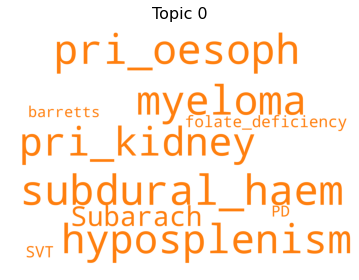

column: weighted_topics_1


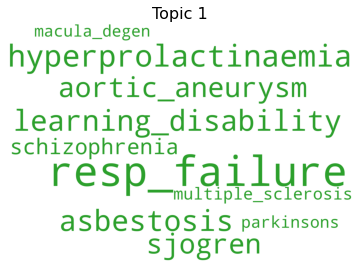

column: weighted_topics_2


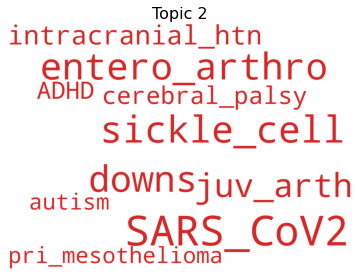

column: weighted_topics_3


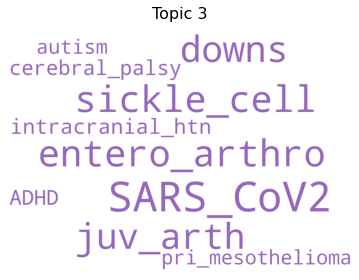

column: weighted_topics_4


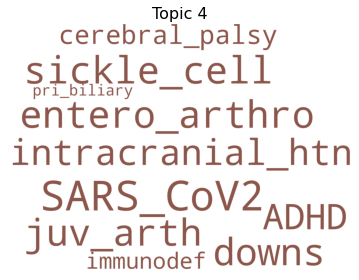

In [14]:
createWordClouds(terms_topics_df, topics_count)

## compute the tensor that holds the patient-topic association __for each term in the patient's history__


In [16]:
##########################
### compute the tensor that holds the patient-topic association __for incremental bag of terms in the patient's history__
##########################


# look up each term in bowStage. add up all partial association strength for each topic, generating an array of size K = number of topic
def assoc(bowstage, terms_topics_df, weighted_cols_names, topics_count):

    assocVector = np.zeros(topics_count)
    
    for term in bowstage:
        row = terms_topics_df.loc[terms_topics_df['MLTC'] == term]
                 
        for i in range( len(weighted_cols_names)):
            assocVector[i] += row[weighted_cols_names[i]]

    return assocVector



## main method to compute the 'tensor' as a nested dictionary:
# bows = list(bow)
# bow = list(bowStage)
# bowStage = list(term)
# term --> association vector of size K = number of topics
# so:
#    all_patients_traj = { id(bow): one_patient_trajectory}
#    one_patient_trajectory = { id(bowStage): assoc vector}
#  to use hashing we need to create an id for each bow (id=patient) and one id for each stage in that patient's history.
#  note that these are not the native patient IDs which are lost at this point
#
# return all_patients_traj
#

def computeTrajectoryAssociations(bows, terms_topics_df, topics_columns, topics_count):

    bowID2bow = dict()  ## need to use bowIDs as hash keys so this dict maps bowID to the actual bow content
    bowId = 1 # makes hashing possible
    all_patients_traj = dict()  ## top level dict
    
    for bow in bows:    # for each bag of word (each patient)
#         print("processing bowId {0}: [{1}]".format(bowId, bow))
        
        bowID2bow[bowId] = bow
        traj = all_patients_traj[bowId] = dict()  ## individual trajectory is itself a dict()
        bowStageId = 1
        for bowStage in getStages(bow):  # compute association vector for each of its stages
#             print("processing bowStage [{0}]".format(bowStage))
            
            traj[bowStageId]  = assoc(bowStage, terms_topics_df, topics_columns, topics_count)
#             print("vector for bowStageId [{0}]: {1}".format(bowStageId, traj[bowStageId]))
            bowStageId += 1
#         print("trajectory: {0}\n".format(traj))
        bowId += 1
        if bowId % 1000 == 0:
            print("{0} patients processed".format(bowId))
#             break
            
    ## save main trajectories data structure

    ALL_TRAJECTORIES_SUFF = path.dirname(ALL_TRAJECTORIES)+  "/"+ path.basename(ALL_TRAJECTORIES).split('.')[0]+ "_"+ str(topics_count)+"."+path.basename(ALL_TRAJECTORIES).split('.')[1]
    BOWID2BOW_SUFF = path.dirname(BOWID2BOW)+  "/"+ path.basename(BOWID2BOW).split('.')[0]+ "_"+ str(topics_count)+"."+path.basename(BOWID2BOW).split('.')[1]
        
    with open(ALL_TRAJECTORIES, 'wb') as f:
        pickle.dump(all_patients_traj, f)

    with open(BOWID2BOW, 'wb') as f:
        pickle.dump(bowID2bow, f)

    return all_patients_traj, bowID2bow

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# hist = ['OA', 'skin_ulcer', 'dermatitis', 'erectile_dysfunction', 'pri_skin']
# hist = ['OA', 'skin_ulcer', 'dermatitis']
# hist  = ['spondylosis', 'obesity', 'urine_incont', 'female_genital_prolapse', 'type_2_diabetes', 'unspecified_rare_diabetes', 'fracture_hip']
# hist = ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']
# hist = ['venous_lymphatic', 'psoriasis', 'female_genital_prolapse', 'CHD', 'alcohol_depend', 'obesity', 'hearing_loss', 'urine_incont']
# hist = ['PTSD', 'COPD', 'neuro_bladder', 'female_genital_prolapse', 'OA'] 
# hist = ['dermatitis', 'hypertension', 'atrial_fibrilation', 'OA', 'tinnitus']

# bows = [['OA', 'skin_ulcer', 'dermatitis'],['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']]

if exists(ALL_TRAJECTORIES) and exists(BOWID2BOW) and not FORCE_RECOMPUTE:
    with open(ALL_TRAJECTORIES, 'rb') as f:
      trajectories =  pickle.load(f)
      print('loaded trajectories [{0}] from cache'.format(ALL_TRAJECTORIES))

    with open(BOWID2BOW, 'rb') as g:
      bowId2bow =  pickle.load(g)
      print('loaded bowId2bow [{0}] from cache'.format(BOWID2BOW))

else:
    print("starting computation of *all* trajectories for {0} bows (= patients)".format(len(bows)))
    trajectories, bowId2bow = computeTrajectoryAssociations(bows, terms_topics_df, topics_columns, topics_count)



loaded trajectories [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/trajectories.pkl] from cache
loaded bowId2bow [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/BowId2bow.pkl] from cache


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:

    trajectories


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{1: {1: array([0.08458479, 0.08311714, 0.09571392, 0.20381455]),
  2: array([0.25880348, 0.22667482, 0.34461816, 0.56826565]),
  3: array([0.36990775, 0.31389787, 0.49799055, 0.73690807]),
  4: array([0.64066672, 0.53325281, 0.75638577, 1.15359539]),
  5: array([0.89111462, 0.79199652, 1.02123295, 1.48544841])},
 2: {1: array([0.29426924, 0.23229351, 0.30685942, 0.32560573]),
  2: array([0.88868814, 0.72593679, 0.96389164, 0.71724094]),
  3: array([1.13173687, 0.91962032, 1.23256816, 0.86573704]),
  4: array([1.355941  , 1.14722905, 1.55245385, 1.04026226]),
  5: array([1.58824158, 1.38801367, 1.8284556 , 1.21164428]),
  6: array([1.84468273, 1.69584312, 2.18501937, 1.42426866]),
  7: array([2.08410257, 1.98290926, 2.49616519, 1.60776395])},
 3: {1: array([0.27075898, 0.21935494, 0.25839522, 0.41668732]),
  2: array([0.42404776, 0.3924801 , 0.45602457, 0.5273388 ]),
  3: array([0.72741525, 0.73748234, 0.83708136, 0.74484449]),
  4: array([1.05719106, 1.08197927, 1.21095339, 0.98750094]